In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import dates
import pandas_ta as ta
import plotly.graph_objects as go
import plotly.express as px
from ta.momentum import RSIIndicator
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [15]:
data = pd.read_csv('./cotton/PCOTTINDUSDM.csv', parse_dates = True).round(2)
data.head()

,DATE,PCOTTINDUSDM
0,1990-01-01,75.20
1,1990-02-01,75.96
2,1990-03-01,78.90
3,1990-04-01,82.87
4,1990-05-01,85.60


In [16]:
data.tail()

,DATE,PCOTTINDUSDM
413,2024-06-01,83.24
414,2024-07-01,81.38
415,2024-08-01,79.93
416,2024-09-01,82.56
417,2024-10-01,83.69


In [17]:
data = data.rename(columns={'PCOTTINDUSDM': 'Cotton Price'})

In [18]:
fig = px.line(data, x='DATE', y='Cotton Price', title='Cotton Price in USD')
fig.update_layout(yaxis=dict(title=dict(text='USD')))
fig.show()

March 2011: https://www.ft.com/content/3d876e64-35c9-11e0-b67c-00144feabdc0

May 2022: https://www.cotlook.com/information-2/cotlook-monthly/may-2022-market-summary/#

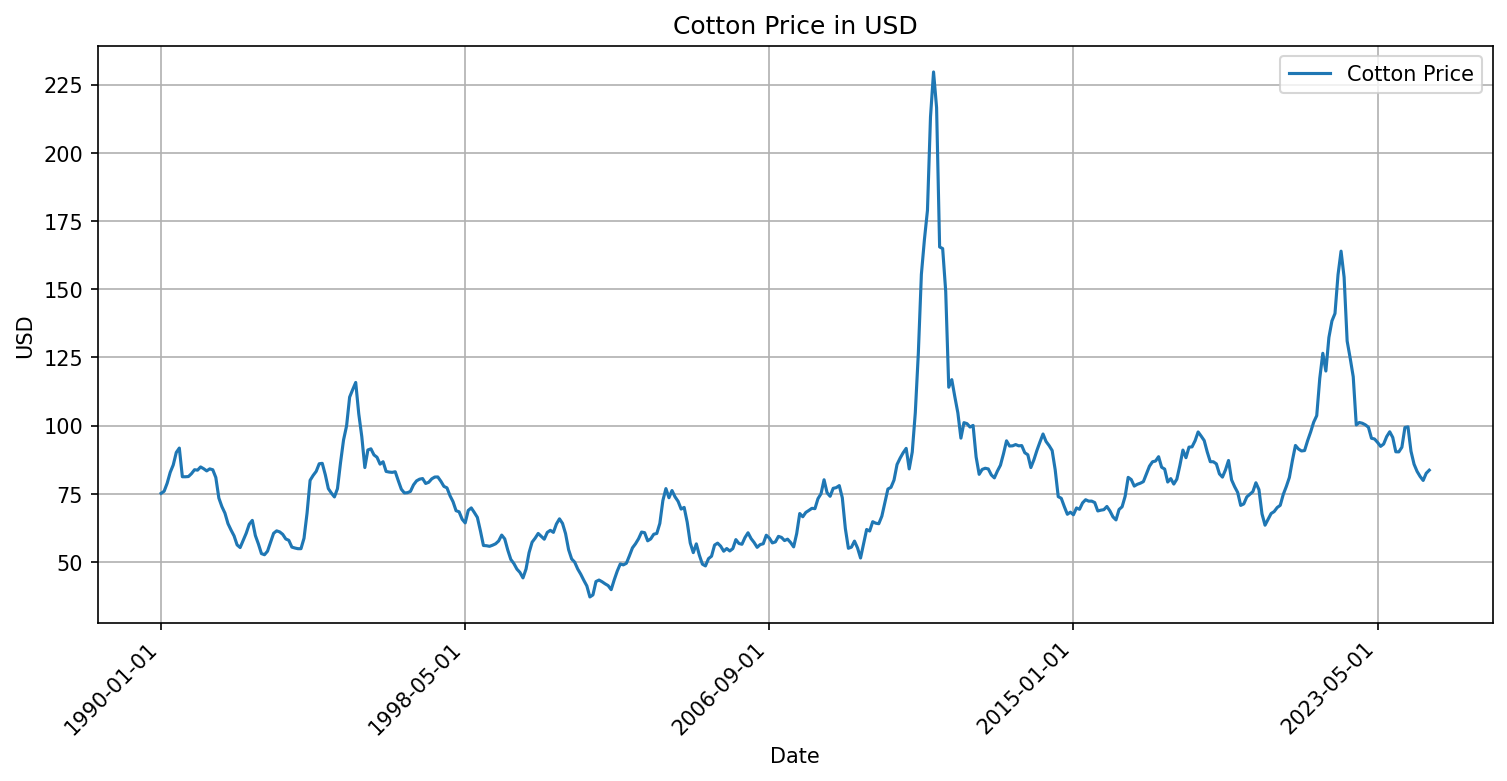

In [19]:
plt.figure(figsize=(12, 5), dpi=150)
ax = data.plot(x='DATE', y='Cotton Price', ax=plt.gca())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Cotton Price in USD')

ax.xaxis.grid(True)
ax.yaxis.grid(True)

plt.show()


# 📊 Relative Strength Index (RSI)

## What is RSI?
- RSI is a momentum oscillator that measures speed and magnitude of price movements.
- **Range**: 0 to 100
  - **Above 70**: Overbought (potential sell signal).
  - **Below 30**: Oversold (potential buy signal).

## RSI Formula
1. **Relative Strength (RS)**:
   \[
   RS = \frac{\text{Average Gain}}{\text{Average Loss}}
   \]
2. **RSI**:
   \[
   RSI = 100 - \frac{100}{1 + RS}
   \]

---

## Key Points
- **Overbought (RSI > 70)**: Price may fall soon.
- **Oversold (RSI < 30)**: Price may rise soon.



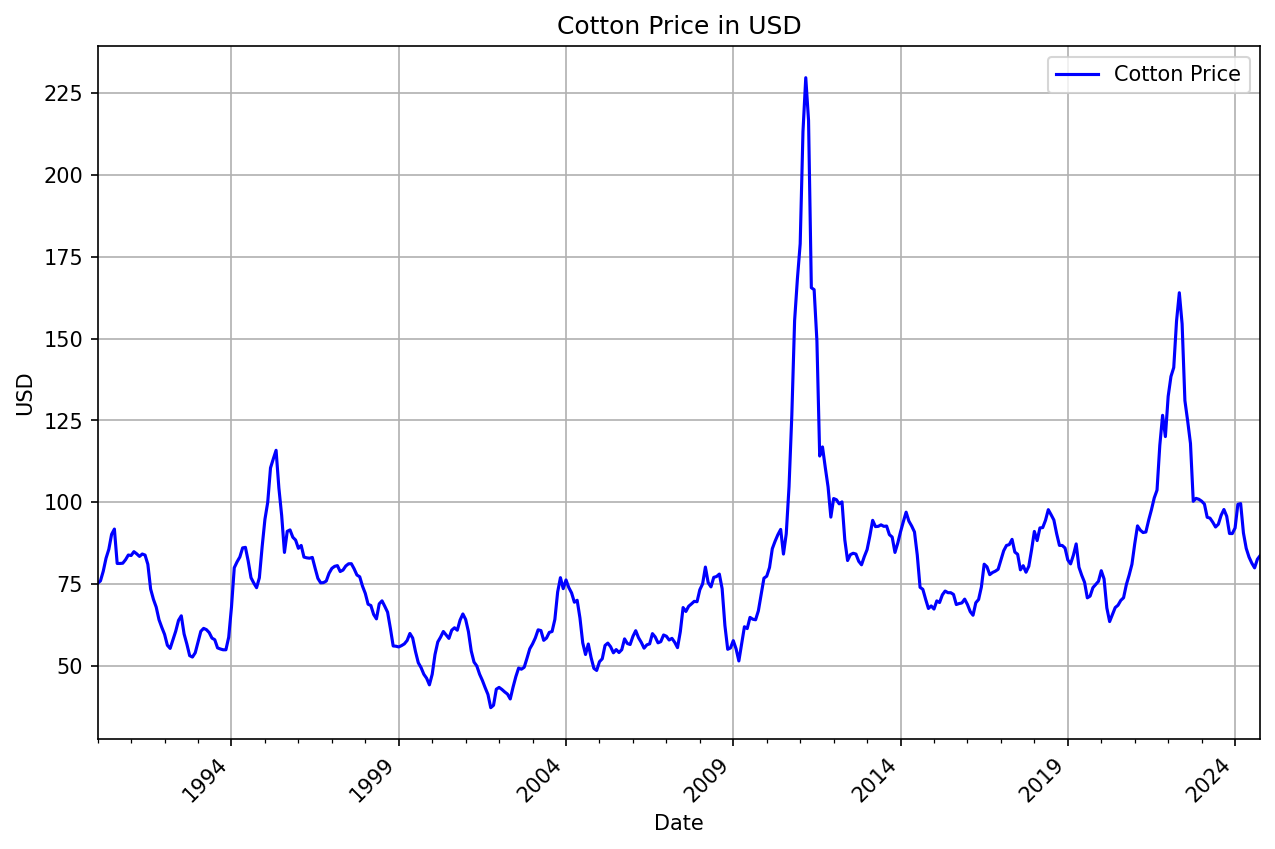

In [20]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

rsi_indicator = RSIIndicator(close=data["Cotton Price"], window=14)
data['RSI'] = rsi_indicator.rsi()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=150)
data['Cotton Price'].plot(ax=ax1, color='blue', label='Cotton Price')
ax1.set_title('Cotton Price in USD')
ax1.set_xlabel('Date')
ax1.set_ylabel('USD')
ax1.grid(True)
ax1.legend()
plt.xticks(rotation=45, ha='right')

plt.show()

rsi_fig = go.Figure(data=[
    go.Scatter(x=data.index, y=data['RSI'], mode='lines', name='RSI', line=dict(color='blue'))
])

rsi_fig.update_layout(
    title='Cotton Price RSI',
    xaxis_title='Date',
    yaxis_title='RSI Value',
    xaxis_rangeslider_visible=False,
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)

rsi_fig.add_shape(type="line", x0=data.index.min(), y0=30, x1=data.index.max(), y1=30,
                  line=dict(color="green", dash="dash"), name="Oversold (30)")
rsi_fig.add_shape(type="line", x0=data.index.min(), y0=70, x1=data.index.max(), y1=70,
                  line=dict(color="red", dash="dash"), name="Overbought (70)")
rsi_fig.show()

# 📊 Moving Averages (M10 and M20)

## What are Moving Averages?
- **Moving Averages (MA)** are technical indicators that smooth out price data by calculating an average price over a specific period.
- They help identify trends by reducing short-term fluctuations.
- Types:
  - **M10 (10-Period Moving Average)**: Calculates the average of the last 10 periods.
  - **M20 (20-Period Moving Average)**: Calculates the average of the last 20 periods.

---

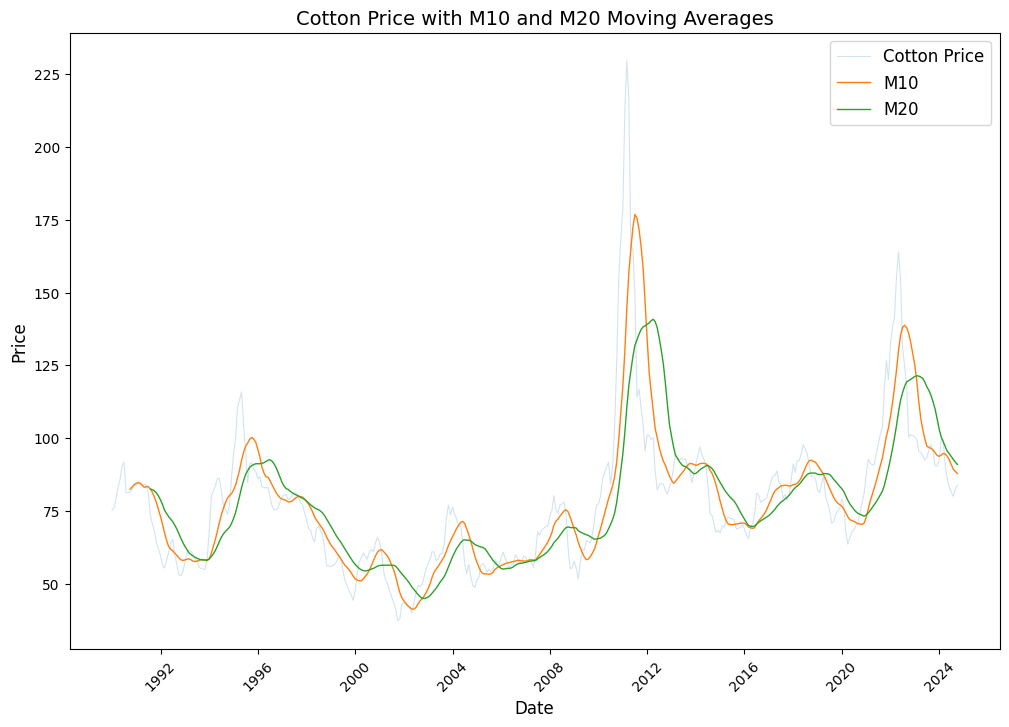

In [21]:
data['M10'] = data['Cotton Price'].rolling(window=10).mean()
data['M20'] = data['Cotton Price'].rolling(window=20).mean()

plt.figure(figsize=(12,8))
plt.plot(data.index, data['Cotton Price'], label='Cotton Price', linewidth=0.8, alpha=0.2)

plt.plot(data.index, data['M10'], label='M10', linewidth=1, alpha=1)
plt.plot(data.index, data['M20'], label='M20', linewidth=1, alpha=1)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Cotton Price with M10 and M20 Moving Averages', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 📊 Bollinger Bands (BB)

## What Are Bollinger Bands?
- Volatility indicator with:
  - **Upper Band (UB)**: Middle Band + 2 standard deviations.
  - **Lower Band (LB)**: Middle Band - 2 standard deviations.
  - **Middle Band (MB)**: 20-period Moving Average.
- **Wider Bands** = High Volatility, **Narrower Bands** = Low Volatility.

---

## 📈 How to Use Bollinger Bands

### 🟥 **When Price Touches Upper Band**:
- **Interpretation**: Overbought (possible reversal).
- **Action**:
  - Consider selling or taking profits.
  - Confirm with RSI (>70 = overbought).

### 🟩 **When Price Touches Lower Band**:
- **Interpretation**: Oversold (possible rebound).
- **Action**:
  - Consider buying.
  - Confirm with RSI (<30 = oversold).

In [22]:
#Prepare and calculate BB
data['SD'] = data['Cotton Price'].rolling(window=20).std()
data['UB'] = data['M20'] + 2 * data['SD']
data['LB'] = data['M20'] - 2 * data['SD']

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['UB'], mode='lines', name='Upper Bollinger Band', visible=True, line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['M20'], mode='lines', name='Middle Bollinger Band', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data.index, y=data['Cotton Price'], mode='lines', name='Price (Bollinger)', visible=True, line=dict(color='black')))
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title='Cotton Price Bolinger Bands',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()

# 📈 Prophet: Time Series Forecasting

## What is Prophet?
- **Prophet** is an open-source forecasting tool developed by Facebook for time series data.
- It is designed to handle:
  - **Trend**: Long-term increases or decreases.
  - **Seasonality**: Periodic patterns (daily, weekly, yearly).
  - **Holidays/Events**: Custom events that influence trends.

---

## Key Features
1. **Automatic Trend Detection**:
   - Identifies and models linear or non-linear trends with changepoints.
2. **Seasonality Handling**:
   - Captures weekly, monthly, and yearly seasonality patterns.
3. **Customizable**:
   - Supports adding external regressors, holidays, or custom seasonality.
4. **Robust to Missing Data**:
   - Handles missing data and outliers effectively.
5. **Interpretability**:
   - Outputs components of the forecast (trend, seasonality) for easy understanding.

---

## Prophet Workflow
1. **Prepare Data**:
   - Rename columns: `DATE` → `ds` (timestamp), `Value` → `y` (target).
2. **Fit Model**:
   - Train the model using historical data.
3. **Make Predictions**:
   - Generate future dates and forecast values.

---

In [23]:
data.reset_index(inplace=True)
prophet_data = data[['DATE', 'Cotton Price']].rename(columns={'DATE': 'ds', 'Cotton Price': 'y'})

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future_dates = prophet_model.make_future_dataframe(periods=12, freq='MS')  # Next 12 months
forecast = prophet_model.predict(future_dates)

forecast[['ds', 'yhat']].tail(12)

20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
418,2024-11-01,94.189839
419,2024-12-01,96.231434
420,2025-01-01,99.551169
421,2025-02-01,103.527419
422,2025-03-01,101.406997
423,2025-04-01,101.432203
424,2025-05-01,100.595042
425,2025-06-01,100.224307
426,2025-07-01,98.707387
427,2025-08-01,96.066644


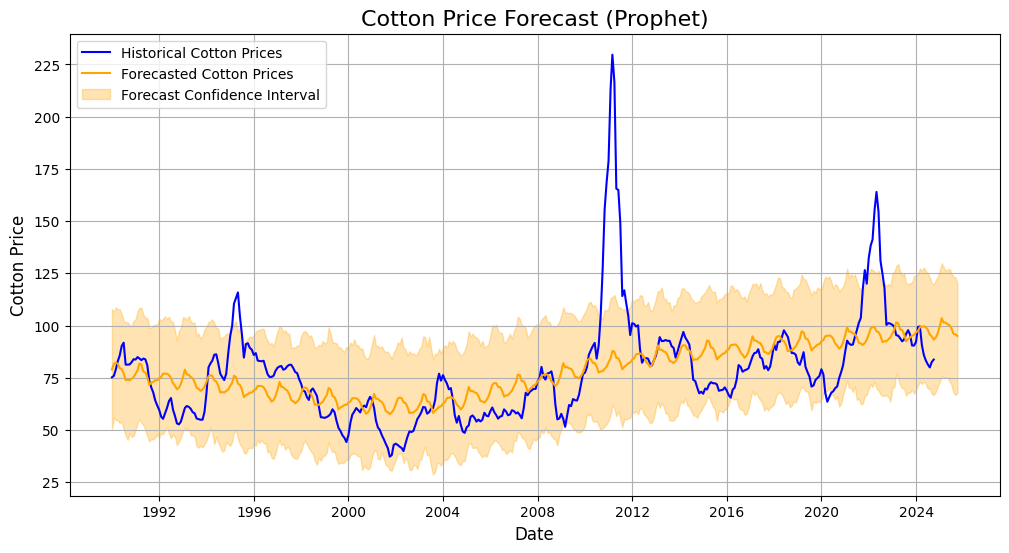

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Cotton Prices', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cotton Prices', color='orange')

plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='orange', 
    alpha=0.3, 
    label='Forecast Confidence Interval'
)

plt.title('Cotton Price Forecast (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cotton Price', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Regression

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
data.head()

,DATE,Cotton Price,RSI,M10,M20,SD,UB,LB
0,1990-01-01,75.20,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-01,75.96,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-03-01,78.90,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-04-01,82.87,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-05-01,85.60,NaN,NaN,NaN,NaN,NaN,NaN
